# Basic Thicket Tutorial: Thicket 101

Thicket is a python-based toolkit for Exploratory Data Analysis (EDA) of parallel performance data that enables performance optimization and understanding of applications’ performance on supercomputers. It bridges the performance tool gap between being able to consider only a single instance of a simulation run (e.g., single platform, single measurement tool, or single scale) and finding actionable insights in multi-dimensional, multi-scale, multi-architecture, and multi-tool performance datasets.

**NOTE: An interactive version of this notebook is available in the Binder environment.**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llnl/thicket-tutorial/develop)

***

## 1. Import Necessary Packages

To explore the structure and various capabilities of thicket components, we begin by importing necessary packages. These include python extensions and thicket's statistical functions.

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import HTML
import hatchet as ht

import thicket as tt

display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>

## 2. Read in Performance Profiles

For this notebook, we select profiles generated on Lawrence Livermore National Lab (LLNL) machine, lassen. We create two thicket objects, one generated with the same block size of 128 and the other generated with different block sizes (128 and 256).   

In [2]:
problem_sizes = ["1048576", 
                 "2097152", 
                 "4194304", 
                 "8388608",
                ]
lassen1 = [f"../data/lassen/clang10.0.1_nvcc10.2.89_{x}/Base_CUDA-block_128.cali" for x in problem_sizes]
lassen2 = [f"../data/lassen/clang10.0.1_nvcc10.2.89_1048576/Base_CUDA-block_256.cali"]

# generate thicket(s)
th_lassen = tt.Thicket.from_caliperreader(lassen1)
th_obj = tt.Thicket.from_caliperreader(lassen1 + lassen2)

## 3. More Information on a Function

You can use the `help()` method within Python to see the information for a given object. You can do this by typing `help(object)`. 
This will allow you to see the arguments for the function, and what will be returned. An example is below.

In [3]:
help(tt.median)

Help on function median in module thicket.stats.median:

median(thicket, columns=None)
    Calculate the median for each node in the performance data table.
    
    Designed to take in a thicket, and append one or more columns to the
    aggregated statistics table for the median calculation for each node.
    
    Arguments:
        thicket (thicket): Thicket object
        columns (list): List of hardware/timing metrics to perform median calculation
            on. Note, if using a columnar joined thicket a list of tuples must be passed
            in with the format (column index, column name).



## 4. Thicket Components

### 4.1 Performance Data

The performance data table is a multi-dimensional, multi-indexed component of thicket. The rows represent nodes that each contain a different execution (i.e., profile index) of the associated call tree node. 


#### View performance data table

In [4]:
display(HTML(th_lassen.dataframe.to_html()))

#### Composing multiple thickets
We can compose thickets in a hierarchical, horizontal ordering using thicket's `columnar_join` function. In this example, we compose profiles of four different problem sizes and four different block sizes seamlessly.

In [5]:
data = {
    "block_128": [f"../data/lassen/clang10.0.1_nvcc10.2.89_{x}/Base_CUDA-block_128.cali" for x in problem_sizes],
    "block_256": [f"../data/lassen/clang10.0.1_nvcc10.2.89_{x}/Base_CUDA-block_256.cali" for x in problem_sizes],
    "block_512": [f"../data/lassen/clang10.0.1_nvcc10.2.89_{x}/Base_CUDA-block_512.cali" for x in problem_sizes],
    "block_1024": [f"../data/lassen/clang10.0.1_nvcc10.2.89_{x}/Base_CUDA-block_1024.cali" for x in problem_sizes],
}

In [6]:
block_128 = tt.Thicket.from_caliperreader(data["block_128"])
block_256 = tt.Thicket.from_caliperreader(data["block_256"])
block_512 = tt.Thicket.from_caliperreader(data["block_512"])
block_1024 = tt.Thicket.from_caliperreader(data["block_1024"])

In [7]:
th_cj = tt.Thicket.columnar_join(
    thicket_list=[block_128, block_256, block_512, block_1024],
    header_list=["Block 128", "Block 256", "Block 512", "Block 1024"],
    column_name="ProblemSizeRunParam"
)

#### View combined thicket's performance data

In [8]:
display(HTML(th_cj.dataframe.to_html()))

### 4.2 Metadata

The metadata table stores HPC simulation information such as an application’s build settings and execution context. A row corresponds to a single execution of the application and is identified by a unique profile index.

#### View metadata table:

In [9]:
display(HTML(th_lassen.metadata.to_html()))

,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,cmdline,cluster,perfsuite_version,raja_version,cmake_build_type,cmake_cxx_flags,cmake_exe_linker_flags,rajaperf_compiler,rajaperf_compiler_options,compiler_version,compiler,Compiler_path_version,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-6232983296743574852,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#sum#time.duration,avg#inclusive#sum#time.duration,sum#inclusive#sum#time.duration,any#any#max#BlockSize,any#any#max#Bytes/Rep,any#any#max#Flops/Rep,any#any#max#Iterations/Rep,any#any#max#Kernels/Rep,any#any#max#ProblemSize,any#any#max#Reps",,2,,regionprofile,spot,mckinsey,1691446615,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /lib64/librt.so.1, /usr/workspace/asde/caliper-lassen/lib64/libcaliper.so.2, /usr/workspace/wsb/asde/adiak-lassen/lib/libadiak.so, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpiprofilesupport.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpi_ibm.so.3, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libstdc++.so.6, /lib64/libm.so.6, /usr/tce/packages/clang/clang-10.0.1/release/lib/libomp.so, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libgcc_s.so.1, /lib64/libc.so.6, /lib64/ld64.so.2, /usr/tce/packages/cuda/cuda-10.1.243/nvidia/lib64/libnvToolsExt.so.1, /usr/tce/packages/cuda/cuda-10.1.243/bin/../extras/CUPTI/lib64/libcupti.so.10.1, /lib64/libpapi.so.5.2.0.0, /lib64/libdw.so.1, /lib64/libunwind.so.8, /usr/tce/packages/xl/xl-2021.09.22/lib/libibmc++.so.1, /lib64/libutil.so.1, /lib64/libz.so.1, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libhwloc_ompi.so.15, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libevent-2.1.so.6, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libevent_pthreads-2.1.so.6, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libopen-rte.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libopen-pal.so.3, /lib64/libpfm.so.4, /lib64/libsensors.so.4, /lib64/libelf.so.1, /lib64/liblzma.so.5, /lib64/libbz2.so.1, /usr/tce/packages/clang/clang-10.0.1/release/lib/libarcher.so, /lib64/libnss_files.so.2]","[../bin/nvcc10.2.89_clang10.0.1.exe, --variants, Base_CUDA, RAJA_CUDA, --tunings, block_128, block_256, block_512, block_1024, library, --size, 1048576, --outdir, /usr/workspace/thicket/rajaperf-july-2023/lassen/clang10.0.1_nvcc10.2.89_1048576/1, -sp]",lassen,1.10.0,2022.10.5,Release,-Wall -Wextra,,/usr/tce/packages/cuda/cuda-10.2.89/bin/nvcc;/usr/tce/packages/clang/clang-10.0.1/bin/clang++,,10.0.1,clang++-10.0.1,clang-10.0.1,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,1048576.0,Direct,4.5,20,Base_CUDA,block_128
1246693022946911723,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#sum#time.duration,avg#inclusive#sum#time.duration,sum#inclusive#sum#time.duration,any#any#max#BlockSize,any#any#max#Bytes/Rep,any#any#max#Flops/Rep,any#any#max#Iterations/Rep,any#any#max#Kernels/Rep,any#any#max#ProblemSize,any#any#max#Reps",,2,,regionprofile,spot,mckinsey,1691449546,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /lib64/librt.so.1, /usr/workspace/asde/caliper-lassen/lib64/libcaliper.so.2, /usr/workspace/wsb/asde/adiak-lassen/lib/libadiak.so, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpiprofilesupport.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpi_ibm.so.3, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libstdc++.so.6, /lib64/libm.so.6, /usr/tce/packages/clang/clang-10.0.1/release/lib/libomp.so, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libgcc_s.so.1, /lib64/libc.so.6, /lib64/ld64.so.2, /usr/tce/packages/cuda/cuda-10.1.243/nvidia/lib64/libnvToolsExt.so.1, /usr/tce/packages/cuda/cuda-10.1.243

#### Filter with respect to metadata

The metadata table of a thicket helps select certain variation based on specific metadata. For example, selecting a certain compiler. In this example, we filter the metadata to select the profiles generated with a problem size of `1048576`.

In [10]:
# selecting profiles with specified problem size
filter_metadata_func = lambda x: x["ProblemSizeRunParam"] == 1048576.0
th_example = th_obj.filter_metadata(filter_metadata_func)
display(HTML(th_example.metadata.to_html()))

,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,cmdline,cluster,perfsuite_version,raja_version,cmake_build_type,cmake_cxx_flags,cmake_exe_linker_flags,rajaperf_compiler,rajaperf_compiler_options,compiler_version,compiler,Compiler_path_version,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-6232983296743574852,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#sum#time.duration,avg#inclusive#sum#time.duration,sum#inclusive#sum#time.duration,any#any#max#BlockSize,any#any#max#Bytes/Rep,any#any#max#Flops/Rep,any#any#max#Iterations/Rep,any#any#max#Kernels/Rep,any#any#max#ProblemSize,any#any#max#Reps",,2,,regionprofile,spot,mckinsey,1691446615,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /lib64/librt.so.1, /usr/workspace/asde/caliper-lassen/lib64/libcaliper.so.2, /usr/workspace/wsb/asde/adiak-lassen/lib/libadiak.so, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpiprofilesupport.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpi_ibm.so.3, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libstdc++.so.6, /lib64/libm.so.6, /usr/tce/packages/clang/clang-10.0.1/release/lib/libomp.so, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libgcc_s.so.1, /lib64/libc.so.6, /lib64/ld64.so.2, /usr/tce/packages/cuda/cuda-10.1.243/nvidia/lib64/libnvToolsExt.so.1, /usr/tce/packages/cuda/cuda-10.1.243/bin/../extras/CUPTI/lib64/libcupti.so.10.1, /lib64/libpapi.so.5.2.0.0, /lib64/libdw.so.1, /lib64/libunwind.so.8, /usr/tce/packages/xl/xl-2021.09.22/lib/libibmc++.so.1, /lib64/libutil.so.1, /lib64/libz.so.1, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libhwloc_ompi.so.15, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libevent-2.1.so.6, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libevent_pthreads-2.1.so.6, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libopen-rte.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libopen-pal.so.3, /lib64/libpfm.so.4, /lib64/libsensors.so.4, /lib64/libelf.so.1, /lib64/liblzma.so.5, /lib64/libbz2.so.1, /usr/tce/packages/clang/clang-10.0.1/release/lib/libarcher.so, /lib64/libnss_files.so.2]","[../bin/nvcc10.2.89_clang10.0.1.exe, --variants, Base_CUDA, RAJA_CUDA, --tunings, block_128, block_256, block_512, block_1024, library, --size, 1048576, --outdir, /usr/workspace/thicket/rajaperf-july-2023/lassen/clang10.0.1_nvcc10.2.89_1048576/1, -sp]",lassen,1.10.0,2022.10.5,Release,-Wall -Wextra,,/usr/tce/packages/cuda/cuda-10.2.89/bin/nvcc;/usr/tce/packages/clang/clang-10.0.1/bin/clang++,,10.0.1,clang++-10.0.1,clang-10.0.1,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,1048576.0,Direct,4.5,20,Base_CUDA,block_128
-420726814338077851,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#sum#time.duration,avg#inclusive#sum#time.duration,sum#inclusive#sum#time.duration,any#any#max#BlockSize,any#any#max#Bytes/Rep,any#any#max#Flops/Rep,any#any#max#Iterations/Rep,any#any#max#Kernels/Rep,any#any#max#ProblemSize,any#any#max#Reps",,2,,regionprofile,spot,mckinsey,1691446615,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /lib64/librt.so.1, /usr/workspace/asde/caliper-lassen/lib64/libcaliper.so.2, /usr/workspace/wsb/asde/adiak-lassen/lib/libadiak.so, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpiprofilesupport.so.3, /usr/tce/packages/spectrum-mpi/ibm/spectrum-mpi-rolling-release/lib/libmpi_ibm.so.3, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libstdc++.so.6, /lib64/libm.so.6, /usr/tce/packages/clang/clang-10.0.1/release/lib/libomp.so, /usr/tce/packages/gcc/gcc-4.9.3/lib64/libgcc_s.so.1, /lib64/libc.so.6, /lib64/ld64.so.2, /usr/tce/packages/cuda/cuda-10.1.243/nvidia/lib64/libnvToolsExt.so.1, /usr/tce/packages/cuda/cuda-10.1.243

#### Groupby using the metadata 

The metadata table also supports the grouping of the thicket based on the unique values present in the provided column(s). The following example groups the thicket according to any unique combination of values in the `launchdate` and `ProblemSizeRunParam` columns.

In [11]:
# create sub-thickets from unique values in two columns
grouping_metadata_cols = ["launchdate", "ProblemSizeRunParam"]
sub_thickets = th_lassen.groupby(grouping_metadata_cols)
for th in sub_thickets:
    display(th.metadata)

4  thickets created...
[(1691446615, 1048576.0), (1691446819, 2097152.0), (1691446876, 4194304.0), (1691449546, 8388608.0)]


,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,...,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,
-6232983296743574852,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,,regionprofile,spot,mckinsey,1691446615,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /l...",...,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,1048576.0,Direct,4.5,20,Base_CUDA,block_128


,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,...,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,
5829755423718090206,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,,regionprofile,spot,mckinsey,1691446819,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /l...",...,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,2097152.0,Direct,4.5,20,Base_CUDA,block_128


,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,...,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,
4737801908790309618,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,,regionprofile,spot,mckinsey,1691446876,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /l...",...,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,4194304.0,Direct,4.5,20,Base_CUDA,block_128


,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,libraries,...,cuda_compiler_version,gpu_targets_block_sizes,systype_build,machine_build,ProblemSizeRunParam,SizeMeaning,omp_version,omp_max_threads,variant,tuning
profile,,,,,,,,,,,,,,,,,,,,,
1246693022946911723,2.9.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,,regionprofile,spot,mckinsey,1691449546,"[/lib64/libdl.so.2, /lib64/libpthread.so.0, /l...",...,10.2.89,"128,256,512,1024",blueos_3_ppc64le_ib_p9,lassen709,8388608.0,Direct,4.5,20,Base_CUDA,block_128


### 4.3 Aggregated Statistics

The aggregated statistics in a thicket is a GraphFrame. Therefore, it contains a graph and corresponding dataframe component. The table supports an order-reduction mechanism and stores processed applications’ performance. Each row of the aggregated statistics table holds data aggregated across all profiles associated with a particular call tree node. Below is an example of an empty aggregated statistics table 


#### View aggregated statistics table

In [12]:
display(HTML(th_lassen.statsframe.dataframe.to_html()))

,name
node,
"{'name': 'RAJAPerf', 'type': 'function'}",RAJAPerf
"{'name': 'Algorithm', 'type': 'function'}",Algorithm
"{'name': 'Algorithm_MEMCPY', 'type': 'function'}",Algorithm_MEMCPY
"{'name': 'Algorithm_MEMSET', 'type': 'function'}",Algorithm_MEMSET
"{'name': 'Algorithm_REDUCE_SUM', 'type': 'function'}",Algorithm_REDUCE_SUM
"{'name': 'Apps', 'type': 'function'}",Apps
"{'name': 'Apps_DEL_DOT_VEC_2D', 'type': 'function'}",Apps_DEL_DOT_VEC_2D
"{'name': 'Apps_ENERGY', 'type': 'function'}",Apps_ENERGY
"{'name': 'Apps_FIR', 'type': 'function'}",Apps_FIR


#### Filter with respect to aggregated statistics

The aggregated statistics table also supports a filter function. In the example below, we filter the table to select the nodes with the names `RAJAPerf`, `Algorithm`, and `Stream_MUL`.

In [13]:
stats_nodes = ["RAJAPerf", "Algorithm", "Stream_MUL"]
th_stats_name = th_obj.filter_stats(lambda x: x["name"] in stats_nodes)
display(HTML(th_stats_name.statsframe.dataframe.to_html()))

,name
node,
"{'name': 'RAJAPerf', 'type': 'function'}",RAJAPerf
"{'name': 'Algorithm', 'type': 'function'}",Algorithm
"{'name': 'Stream_MUL', 'type': 'function'}",Stream_MUL


#### Calculate the median and mean of performance data column, append to aggregated statistics table

The aggregated statistics table allows users to select a column from the performance data to perform an average on the values in a column. After performing the `median()` and `mean()` operation on said column, two new columns are appended to the statistics table with the mean and median values corresponding to the columns provided by the user. 

Below is an example where we calculate the mean and median of the values in the `Total time` column, which is the total exclusive time corresponding to the respective nodes.  

In [14]:
metrics = ["Total time"]
tt.median(th_lassen, columns=metrics)
display(HTML(th_lassen.statsframe.dataframe.to_html()))

/opt/conda/lib/python3.9/site-packages/thicket/stats/median.py:37: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for node in pd.unique(thicket.dataframe.reset_index()["node"].tolist()):


,name,Total time_median
node,,
"{'name': 'RAJAPerf', 'type': 'function'}",RAJAPerf,5.073698
"{'name': 'Algorithm', 'type': 'function'}",Algorithm,0.015522
"{'name': 'Algorithm_MEMCPY', 'type': 'function'}",Algorithm_MEMCPY,0.006589
"{'name': 'Algorithm_MEMSET', 'type': 'function'}",Algorithm_MEMSET,0.004223
"{'name': 'Algorithm_REDUCE_SUM', 'type': 'function'}",Algorithm_REDUCE_SUM,0.004685
"{'name': 'Apps', 'type': 'function'}",Apps,0.435724
"{'name': 'Apps_DEL_DOT_VEC_2D', 'type': 'function'}",Apps_DEL_DOT_VEC_2D,0.019889
"{'name': 'Apps_ENERGY', 'type': 'function'}",Apps_ENERGY,0.111695
"{'name': 'Apps_FIR', 'type': 'function'}",Apps_FIR,0.010903


In [15]:
tt.mean(th_lassen, columns=metrics)
display(HTML(th_lassen.statsframe.dataframe.to_html()))

/opt/conda/lib/python3.9/site-packages/thicket/stats/mean.py:37: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for node in pd.unique(thicket.dataframe.reset_index()["node"].tolist()):


,name,Total time_median,Total time_mean
node,,,
"{'name': 'RAJAPerf', 'type': 'function'}",RAJAPerf,5.073698,6.584067
"{'name': 'Algorithm', 'type': 'function'}",Algorithm,0.015522,0.018886
"{'name': 'Algorithm_MEMCPY', 'type': 'function'}",Algorithm_MEMCPY,0.006589,0.008138
"{'name': 'Algorithm_MEMSET', 'type': 'function'}",Algorithm_MEMSET,0.004223,0.005336
"{'name': 'Algorithm_REDUCE_SUM', 'type': 'function'}",Algorithm_REDUCE_SUM,0.004685,0.005388
"{'name': 'Apps', 'type': 'function'}",Apps,0.435724,0.537407
"{'name': 'Apps_DEL_DOT_VEC_2D', 'type': 'function'}",Apps_DEL_DOT_VEC_2D,0.019889,0.024730
"{'name': 'Apps_ENERGY', 'type': 'function'}",Apps_ENERGY,0.111695,0.138574
"{'name': 'Apps_FIR', 'type': 'function'}",Apps_FIR,0.010903,0.013454


#### Calculate the percentile of performance data column, append to aggregated statistics table

The aggregated statistics table allows users to select a column from the performance data to perform the `percentiles()` operation. This results in a new column appended to the statistics table containing the 25th, 50th, and 75th percentiles of the values in the provided column.

Below is an example where we calculate the percentiles of the values in the same `Total time` column.

In [16]:
tt.percentiles(th_lassen, columns=metrics)
display(HTML(th_lassen.statsframe.dataframe.to_html()))

/opt/conda/lib/python3.9/site-packages/thicket/stats/percentiles.py:46: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for node in pd.unique(thicket.dataframe.reset_index()["node"].tolist()):


,name,Total time_median,Total time_mean,Total time_percentiles
node,,,,
"{'name': 'RAJAPerf', 'type': 'function'}",RAJAPerf,5.073698,6.584067,"[2.98107, 5.0736985, 8.676696]"
"{'name': 'Algorithm', 'type': 'function'}",Algorithm,0.015522,0.018886,"[0.00975225, 0.0155215, 0.024655000000000003]"
"{'name': 'Algorithm_MEMCPY', 'type': 'function'}",Algorithm_MEMCPY,0.006589,0.008138,"[0.00399, 0.0065895, 0.010738]"
"{'name': 'Algorithm_MEMSET', 'type': 'function'}",Algorithm_MEMSET,0.004223,0.005336,"[0.00242625, 0.0042235, 0.00713325]"
"{'name': 'Algorithm_REDUCE_SUM', 'type': 'function'}",Algorithm_REDUCE_SUM,0.004685,0.005388,"[0.003313, 0.0046854999999999996, 0.00676025]"
"{'name': 'Apps', 'type': 'function'}",Apps,0.435724,0.537407,"[0.27799975, 0.43572449999999996, 0.69513175]"
"{'name': 'Apps_DEL_DOT_VEC_2D', 'type': 'function'}",Apps_DEL_DOT_VEC_2D,0.019889,0.024730,"[0.011785499999999999, 0.019889, 0.03283325]"
"{'name': 'Apps_ENERGY', 'type': 'function'}",Apps_ENERGY,0.111695,0.138574,"[0.06655525000000001, 0.111695, 0.1837135]"
"{'name': 'Apps_FIR', 'type': 'function'}",Apps_FIR,0.010903,0.013454,"[0.00671425, 0.010903, 0.017643]"


#### View aggregated statistics call tree

In [17]:
print(th_lassen.statsframe.tree(metric_column="Total time_median"))

    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

5.074 RAJAPerf
├─ 0.016 Algorithm
│  ├─ 0.007 Algorithm_MEMCPY
│  ├─ 0.004 Algorithm_MEMSET
│  └─ 0.005 Algorithm_REDUCE_SUM
├─ 0.436 Apps
│  ├─ 0.020 Apps_DEL_DOT_VEC_2D
│  ├─ 0.112 Apps_ENERGY
│  ├─ 0.011 Apps_FIR
│  ├─ 0.035 Apps_HALOEXCHANGE
│  ├─ 0.007 Apps_HALOEXCHANGE_FUSED
│  ├─ 0.035 Apps_LTIMES
│  ├─ 0.035 Apps_LTIMES_NOVIEW
│  ├─ 0.021 Apps_NODAL_ACCUMULATION_3D
│  ├─ 0.134 Apps_PRESSURE
│  ├─ 0.016 Apps_VOL3D
│  └─ 0.010 Apps_ZONAL_ACCUMULATION_3D
├─ 0.936 Basic
│  ├─ 0.025 Basic_COPY8
│  ├─ 0.047 Basic_DAXPY
│  ├─ 0.047 Basic_DAXPY_ATOMIC
│  ├─ 0.036 Basic_IF_QUAD
│  ├─ 0.080 Basic_INIT3
│  ├─ 0.100 Basic_INIT_VIEW1D
│  ├─ 0.095 Basic_INIT_VIEW1D_OFFSET
│  ├─ 0.056 Basic_MULADDSUB
│  ├─ 0.045 Basic_NESTED_INIT
│  ├─ 0.342 Basic_PI_ATOMIC
│  ├─ 0.004 Basic_PI_REDUCE
│

#### Use the query language

Thicket's query language provides users the capability to select or `query` specific nodes based on the call tree of the thicket. The performance data is then updated as part of the operation. 

**Initial call tree:** 

In [18]:
print(th_lassen.statsframe.tree("Total time_median"))

    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

5.074 RAJAPerf
├─ 0.016 Algorithm
│  ├─ 0.007 Algorithm_MEMCPY
│  ├─ 0.004 Algorithm_MEMSET
│  └─ 0.005 Algorithm_REDUCE_SUM
├─ 0.436 Apps
│  ├─ 0.020 Apps_DEL_DOT_VEC_2D
│  ├─ 0.112 Apps_ENERGY
│  ├─ 0.011 Apps_FIR
│  ├─ 0.035 Apps_HALOEXCHANGE
│  ├─ 0.007 Apps_HALOEXCHANGE_FUSED
│  ├─ 0.035 Apps_LTIMES
│  ├─ 0.035 Apps_LTIMES_NOVIEW
│  ├─ 0.021 Apps_NODAL_ACCUMULATION_3D
│  ├─ 0.134 Apps_PRESSURE
│  ├─ 0.016 Apps_VOL3D
│  └─ 0.010 Apps_ZONAL_ACCUMULATION_3D
├─ 0.936 Basic
│  ├─ 0.025 Basic_COPY8
│  ├─ 0.047 Basic_DAXPY
│  ├─ 0.047 Basic_DAXPY_ATOMIC
│  ├─ 0.036 Basic_IF_QUAD
│  ├─ 0.080 Basic_INIT3
│  ├─ 0.100 Basic_INIT_VIEW1D
│  ├─ 0.095 Basic_INIT_VIEW1D_OFFSET
│  ├─ 0.056 Basic_MULADDSUB
│  ├─ 0.045 Basic_NESTED_INIT
│  ├─ 0.342 Basic_PI_ATOMIC
│  ├─ 0.004 Basic_PI_REDUCE
│

**Example 1**

In the example below, we use a thicket query that only select the parents and children nodes of `Algorithm`, maintaining the structure of the call tree.

NOTE: A `DeprecationWarning` is generated when using “old-style” queries (i.e., queries with `QueryMatcher`) when using the newest version of Hatchet. In the future, queries will be defined with `Query`.

In [19]:
alg_query_ex1 = (
    ht.QueryMatcher()
    .match("*")
    .rel(
        ".", 
        lambda row: row["name"].apply(
        lambda x: re.match(
            r"Algorithm.*", x
        ) 
        is not None).all()
    )
)
    
# applying the query on the lassen thicket
th_algorithm_ex1 = th_lassen.query(alg_query_ex1)
tt.median(th_algorithm_ex1, columns=["Total time"])
print(th_algorithm_ex1.statsframe.tree("Total time_median"))

<ipython-input-19-1088e14106ee>:2: DeprecationWarning: Old-style queries are deprecated and will be removed in the                     future. Please use new-style queries instead.                     For QueryMatcher, the equivalent new-style queries are                     hatchet.query.Query for base-syntax queries and                     hatchet.query.ObjectQuery for the object-dialect.
  ht.QueryMatcher()


    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

5.074 RAJAPerf
└─ 0.016 Algorithm
   ├─ 0.007 Algorithm_MEMCPY
   ├─ 0.004 Algorithm_MEMSET
   └─ 0.005 Algorithm_REDUCE_SUM

Legend (Metric: Total time_median Min: 0.00 Max: 5.07)
█ 4.57 - 5.07
█ 3.55 - 4.57
█ 2.54 - 3.55
█ 1.53 - 2.54
█ 0.51 - 1.53
█ 0.00 - 0.51

name User code    ◀  Only in left graph    ▶  Only in right graph



/opt/conda/lib/python3.9/site-packages/thicket/stats/median.py:37: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for node in pd.unique(thicket.dataframe.reset_index()["node"].tolist()):


**Example 2**

In the example below, we use a thicket query that selects only the `Algorithm` node and its children nodes, maintaining the structure of the call tree.

NOTE: A `DeprecationWarning` is generated when using “old-style” queries (i.e., queries with `QueryMatcher`) when using the newest version of Hatchet. In the future, queries will be defined with `Query`.

In [20]:
alg_query_ex2 = (
    ht.QueryMatcher()
    .match(
        ".",
        lambda row: row["name"].apply(
        lambda x: re.match(
            r"Algorithm.*", x
        ) 
        is not None).all()
    )
    .rel("*")
)

# applying the second query on the lassen thicket
th_algorithm_ex2 = th_lassen.query(alg_query_ex2)
tt.median(th_algorithm_ex2, columns=["Total time"])
print(th_algorithm_ex2.statsframe.tree("Total time_median"))

    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

0.016 Algorithm
├─ 0.007 Algorithm_MEMCPY
├─ 0.004 Algorithm_MEMSET
└─ 0.005 Algorithm_REDUCE_SUM

Legend (Metric: Total time_median Min: 0.00 Max: 0.02)
█ 0.01 - 0.02
█ 0.01 - 0.01
█ 0.01 - 0.01
█ 0.01 - 0.01
█ 0.01 - 0.01
█ 0.00 - 0.01

name User code    ◀  Only in left graph    ▶  Only in right graph



<ipython-input-20-f0f2ab2800d3>:2: DeprecationWarning: Old-style queries are deprecated and will be removed in the                     future. Please use new-style queries instead.                     For QueryMatcher, the equivalent new-style queries are                     hatchet.query.Query for base-syntax queries and                     hatchet.query.ObjectQuery for the object-dialect.
  ht.QueryMatcher()
/opt/conda/lib/python3.9/site-packages/thicket/stats/median.py:37: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for node in pd.unique(thicket.dataframe.reset_index()["node"].tolist()):


#### Display histogram

The `display_histogram()` function allows users to select a node and metric value (a column in the performance data table) for which a histogram is generated.

Some available keyword arguments are the following,

* `height`: height (in inches) of each facet.
* `aspect`: aspect ratio of each facet, aspect * height will give you the width of each facet.
* `bins`: rather generic, and can set the number of bins.
* `binwidth`: width of each bin, overrides bins but can be used with binrange.
* `binrange`: lowest and highest value for bin edges; can be used either with bins or binwidth. Defaults to extremes.
* `color`: Set the color of the bars.

An exhaustive list of available arguments can be found [here](https://seaborn.pydata.org/generated/seaborn.displot.html).   

In [21]:
n = pd.unique(th_algorithm_ex1.dataframe.reset_index()["node"])[0]

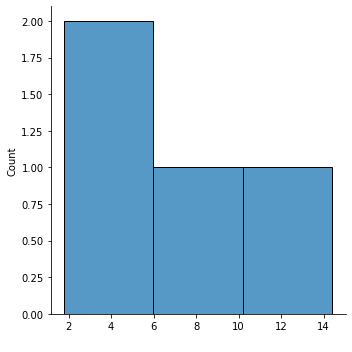

In [22]:
tt.display_histogram(th_algorithm_ex1, node=n, column="Total time")

#### Display heatmap

The `display_heatmap()` function allows users to select column(s) from the performance data table, for which a heatmap is generated based on the values of the column.

Some available keyword arguments are the following: 
* `vmax`: maximum value to anchor the color map.
* `vmin`: minimum value to anchor the color map.
* `linecolor`: color of the lines that will divide each cell.
* `linewidths`: Width of the lines that will divide each cell.

An exhaustive list of available arguments can be found [here](https://seaborn.pydata.org/generated/seaborn.heatmap.html).  

<Axes: ylabel='node'>

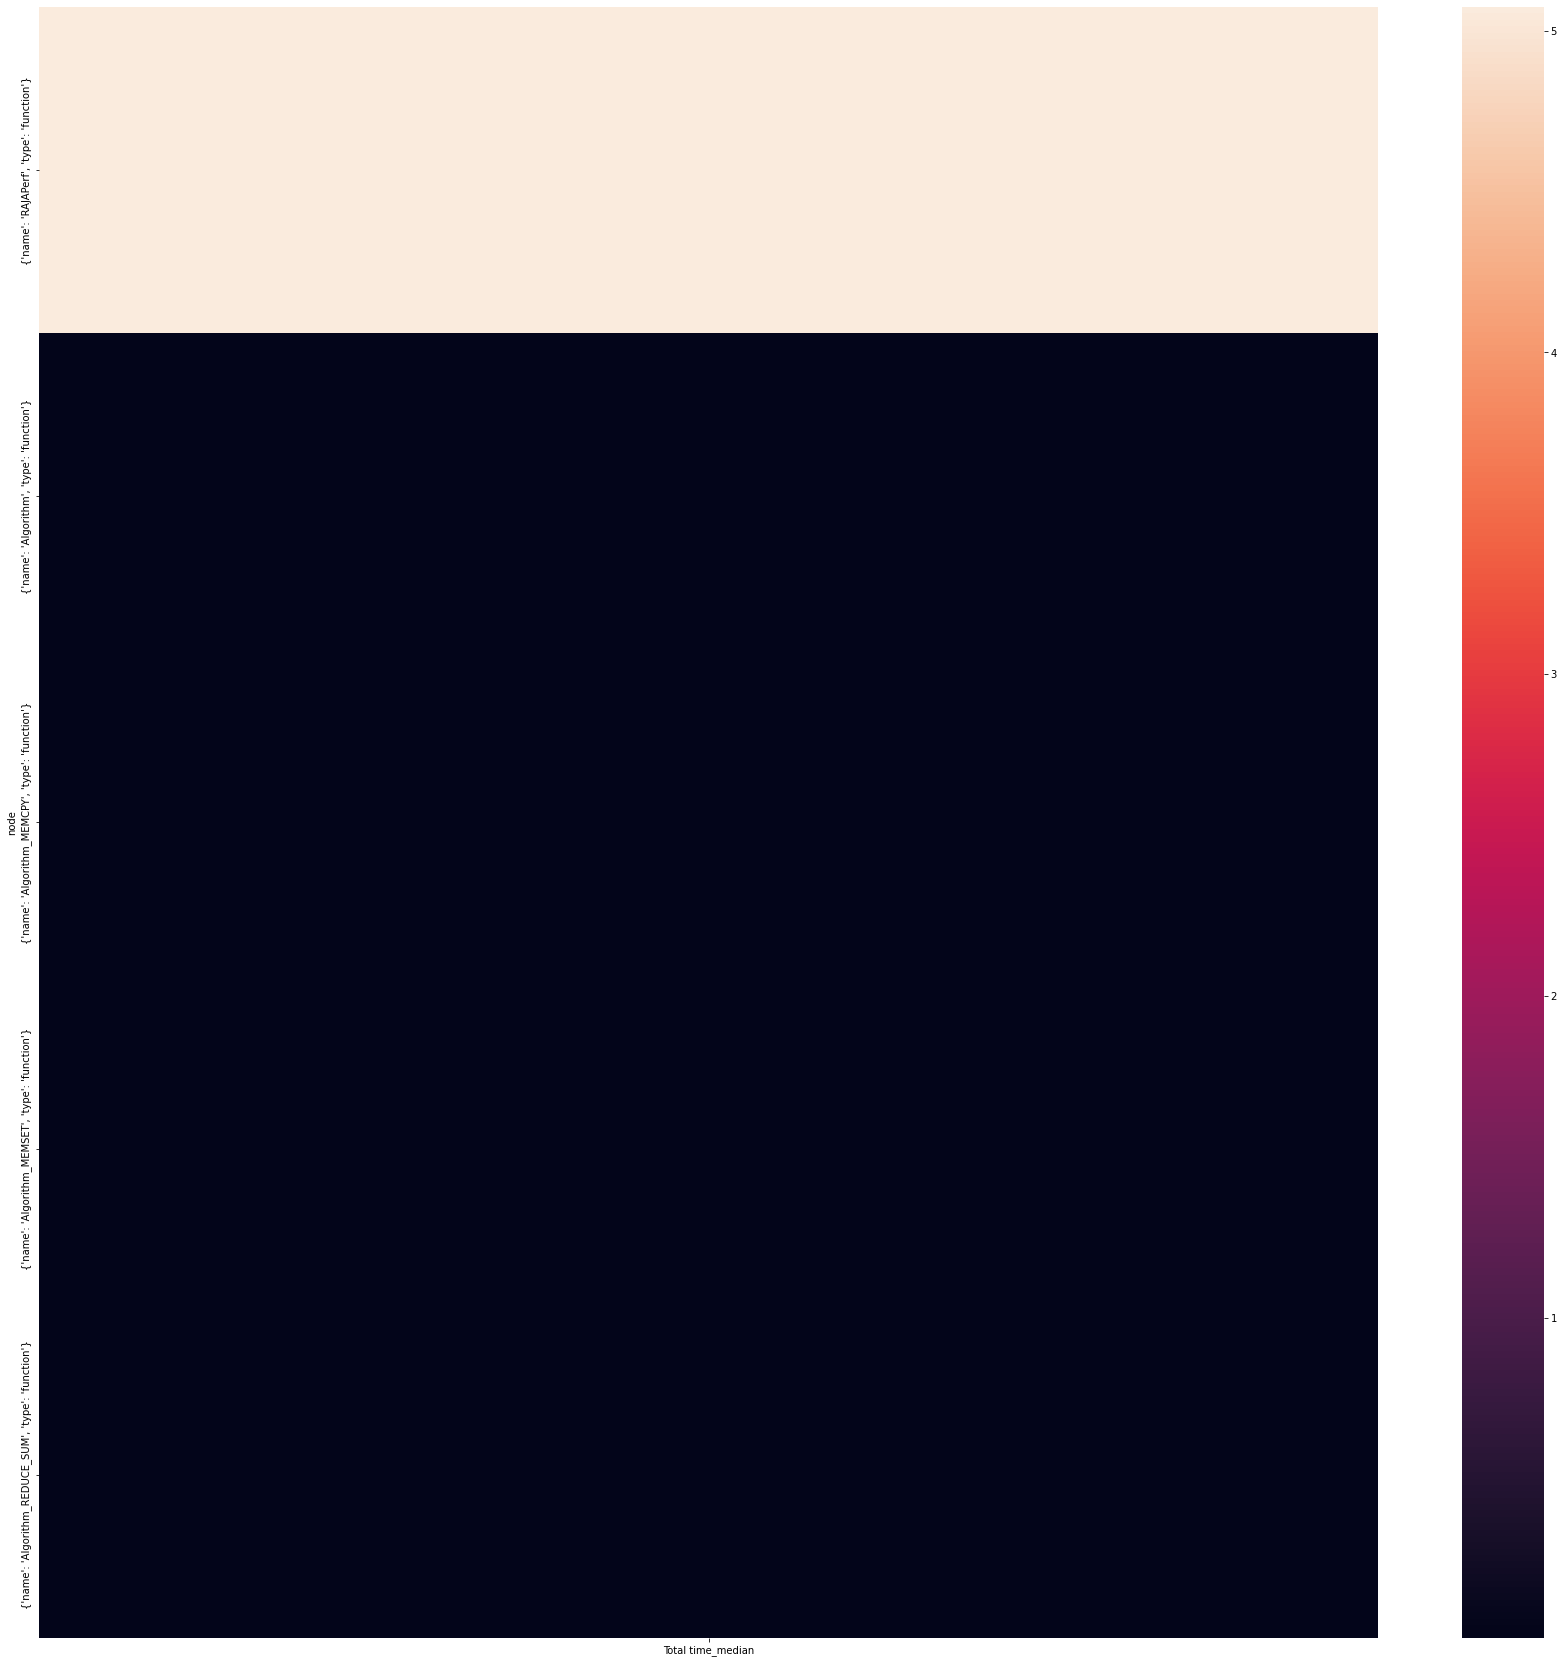

In [23]:
plt.figure(figsize=(30, 30))
metrics = ["Total time_median"]
tt.display_heatmap(th_algorithm_ex1, columns=metrics)